# <font color="gren">**Exercício 6**

## **1-Imports Necessários**

In [658]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d
from scipy import sparse
import math

## **2-Definição da rede**


### Função de definição da rede

In [659]:
def GeraRede(nx,ny,CH,CV):
    nv = nx*ny
    nc = (nx-1)*ny + (ny-1)*nx
    
    conec = np.zeros(shape=(nc,2),dtype=np.int64)
    C = np.zeros(nc)
    
    # Loop sobre canos horizontais
    for j in range(ny):
        for i in range(nx-1):
          k = j*(nx-1) + i
          conec[k,0] = j*nx + i
          conec[k,1] = j*nx + i+1
          C[k] = CH

    # Loop sobre canos verticais
    for i in range(nx):
      for j in range(ny-1):
          k = (nx-1)*ny + j*nx + i
          conec[k,0] = i + j*nx
          conec[k,1] = i + (j+1)*nx
          C[k] = CV

    return nv, nc, conec, C

## **3-Funções de resolução da rede**

### 1- Monta matriz conduc e matriz A

In [660]:
def retorna_conduc(C):
    tam=len(C)
    conduc=np.zeros(shape=(tam,tam),dtype=np.float64)
    for i in range(tam):
        conduc[i][i]=C[i]
    return conduc


def retorna_matriz_A(conec,nc,nv,conduc):
    #Inicia a matriz A que será retornada
    A=np.zeros(shape=(nv,nv),dtype=np.float64)
    
    n1,n2=0,0

    for i in range(nc): # percorre as linhas da matriz de conecções
        
        #recebimento dos nós da linha i da matriz de conecções
        n1,n2=conec[i][0],conec[i][1]

        # adição de elementos conforme a matriz ClocK
        A[n1][n1]=A[n1][n1]+conduc[i][i]    
        A[n1][n2]=A[n1][n2]-conduc[i][i]
        A[n2][n1]=A[n2][n1]-conduc[i][i]
        A[n2][n2]=A[n2][n2]+conduc[i][i]
                        
    
    return A

### 2-Função de formação da matriz Ã e matriz direita

In [661]:

def retorna_matriz_Ã(A,natm):
    rng=len(A[0])
    Ã=A
    for i in range(0,rng):
        if(i==natm):
            Ã[natm][i]=1
        else:
            Ã[natm][i]=0
    return Ã

def retorna_matriz_direita(nv,nB,QB):
    d=np.zeros(nv,dtype=np.float64)
    for i in range(0,nv):
        if(i==nB): d[i]=QB
        else: d[i]=0
    return d



### 3-Função de resolução do sistema e de vazões nodais

In [662]:
def retorna_pressoes(Ã,d):
    #Obtém a matriz exparsa da matriz Ã
    Ã_aux = scipy.sparse.csr_matrix(Ã)

    #Obtém vetor de pressões
    P = sparse.linalg.spsolve(Ã_aux, d)
    return P

def vetor_vazoes_nodos(A,P):
    Q=A@P
    return Q

### 4-Obtenção do vetor de vazões nos canos e da potência da bomba

In [663]:
def retorna_potencia(conduc,D,P):
    Qc=conduc@D@P
    W=(Qc.transpose())@(D@P)
    return W

### 5-Obtenção da matriz D(diferenças)

In [664]:
def retorna_matriz_D(nv,nc,conec):
    l=nc
    c=nv
    D=np.zeros(shape=(l,c),dtype=np.float64)
    for i in range(l):
        n1,n2=conec[i][0],conec[i][1]
        D[i][n1]=1
        D[i][n2]=-1
    return D

### 6-Resolve o sistema

In [665]:
def resolve_sistema(natm,nB,QB,nv,nc,conec,conduc):
    A=retorna_matriz_A(conec,nc,nv,conduc)
    Ã=retorna_matriz_Ã(A,natm)
    d=retorna_matriz_direita(nv,nB,QB)
    P=retorna_pressoes(Ã,d)
    return P
   

### 7-Retorno da potência dissipada em função dos valores variáveis de CH e CV

In [666]:
def potencia_dissipada(nx,ny,nB,QB,natm,CH,CV):
    nv, nc, conec, C = GeraRede(nx,ny,CH,CV)
    conduc=retorna_conduc(C)
    P=resolve_sistema(natm,nB,QB,nv,nc,conec,conduc)
    D=retorna_matriz_D(nv,nc,conec)
    return retorna_potencia(conduc,D,P)  
    

## **4-Definição da função $f(x)$ a ser integrada**


### *OBS: nesse caso deve ser igual a potência dissipado para um valor x*

In [667]:
def f(x):
    #   Pré-setagem
    n=8
    m=9
    natm=m*n - 1
    nB=0
    QB=3

    #   Conductâncias dos canos em função de x
    CH=2.3+10*np.exp(-((x-5)**2))
    CV=1.8+10*np.exp(-((x-5)**2))

    #   Retorna potência dissipada para um dado valor x
    return(potencia_dissipada(n,m,nB,QB,natm,CH,CV)) ##iremos integrar a própria potência

## **5-Definição da função que calcula $\int_a^b f(x) \,dx$**
*(para um dado número de subintervalos)*

### a)Regra do ponto médio

In [668]:
def intg_pm(a,b,N,f):
    h=(b-a)/N ##calcula tamanho das partições
    som=0 ##somatório da fórmula

    x=np.zeros(N+1)
    x[0]=a

    for k in range(1,N+1):
        x[k]=a+h*k ## valores de x a cada partição h
    
    for k in range (1,N+1):##cálculo do somatório
        xb=(x[k-1]+x[k])/2
        som=som+f(xb) 

    return (h*som)

### b)Regra do trapézio

In [669]:
def intg_t(a,b,N,f):
    h=(b-a)/N ##calcula tamanho das partições
    som=0 ##somatório da fórmula

    x=np.zeros(N+1)
    x[0]=a

    for k in range(1,N+1):
        x[k]=a+h*k ## valores de x a cada partição h
    
    for k in range (1,N+1):##cálculo do somatório
        som=som+(f(x[k-1]) + f(x[k]))

    return ((h/2)*som)

### c)Regra de Simpson

In [670]:
def intg_s(a,b,N,f):
    h=(b-a)/N ##calcula tamanho das partições
    som=0 ##somatório da fórmula

    x=np.zeros(N+1)
    x[0]=a

    for k in range(1,N+1):
        x[k]=a+h*k ## valores de x a cada partição h
    
    for k in range (1,N+1):##cálculo do somatório
        xb=(x[k-1]+x[k])/2
        som=som+f(x[k-1])+4*f(xb)+f(x[k]) 

    return ((h/6)*som)

## **6-Obtenção dos valores de potência usando funções da rede**

In [671]:
#   Pré-setagem
n=8
m=9
natm=m*n - 1
nB=0
QB=3

#   Vetor x
x=np.linspace(2,10,5)
rng=len(x)

#   Obtenção do vetor de potências
intg_pont=np.array([])
for i in range (rng):
    CH=2.3+10*np.exp(-((x[i]-5)**2))
    CV=1.8+10*np.exp(-((x[i]-5)**2))
    intg_pont=np.append(intg_pont,potencia_dissipada(n,m,nB,QB,natm,CH,CV))

### Plotagem

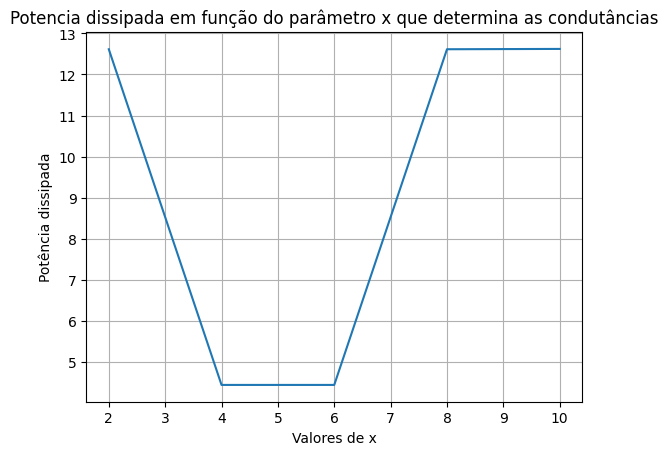

In [672]:
plt.plot(x,intg_pont)
plt.grid()
plt.xlabel('Valores de x')
plt.ylabel('Potência dissipada')
plt.title('Potencia dissipada em função do parâmetro x que determina as condutâncias')
plt.show()

## **7-Obtenção de resultados usando cálculo de integral**

In [673]:
# Vetor de números de subintervalos (N)
lN=5
N=np.linspace(2,10,lN,dtype=int)

#Vetores de integrais de potência:
#a)Usando regra do ponto médio
intg_pont_pm=np.zeros(lN)
for i in range (0,lN):
    intg_pont_pm[i]=intg_pm(1,10,N[i],f)# a=1, b=10, N=N[i], f=f(x)

#b)Usando regra do trapézio
intg_pont_t=np.zeros(lN)
for i in range (0,lN):
    intg_pont_t[i]=intg_t(1,10,N[i],f)

#c)Usando regra de Simpson
intg_pont_s=np.zeros(lN)
for i in range (0,lN):
    intg_pont_s[i]=intg_s(1,10,N[i],f)

### **Plotagem de gráficos das integrais**

*a)Plot para regra do ponto médio*

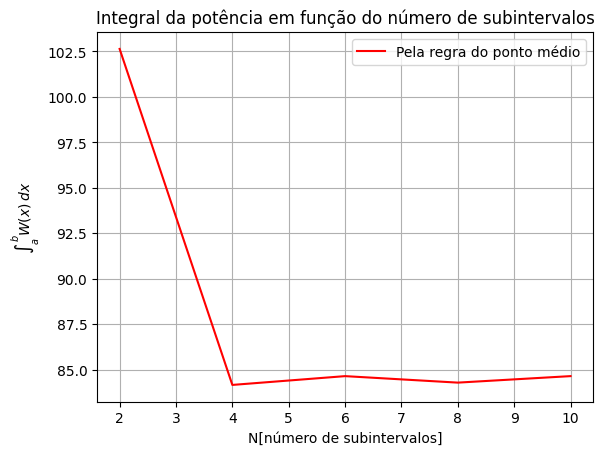

In [674]:
plt.plot(N,intg_pont_pm,'-r')
plt.grid()
plt.legend(['Pela regra do ponto médio'])
plt.xlabel('N[número de subintervalos]')
plt.ylabel('$\int_a^b W(x) \,dx$')
plt.title('Integral da potência em função do número de subintervalos')
plt.show()

*b)Plot para regra do trapézio*

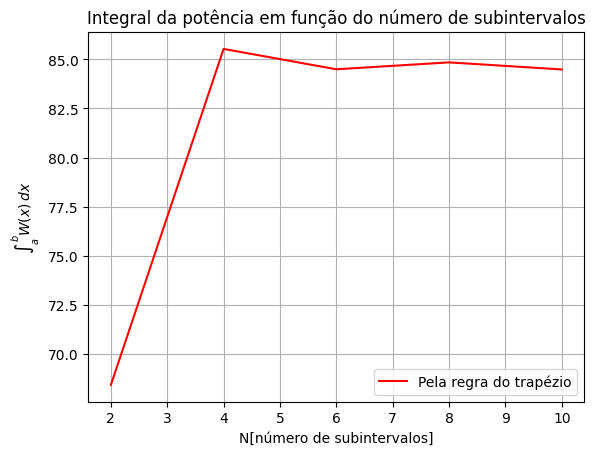

In [675]:
plt.plot(N,intg_pont_t,'-r')
plt.grid()
plt.legend(['Pela regra do trapézio'])
plt.xlabel('N[número de subintervalos]')
plt.ylabel('$\int_a^b W(x) \,dx$')
plt.title('Integral da potência em função do número de subintervalos')
plt.show()

*c)Plot para regra de simpson*

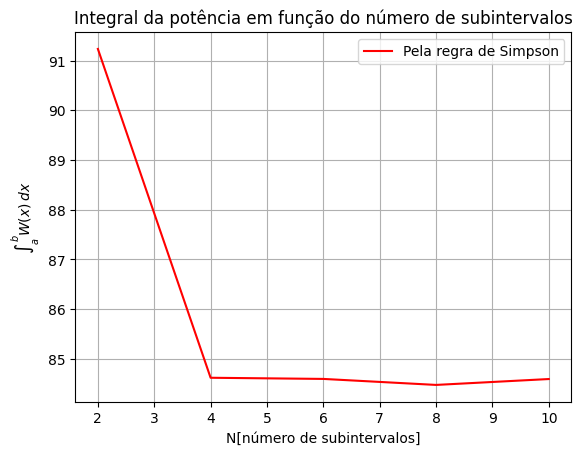

In [676]:
plt.plot(N,intg_pont_s,'-r')
plt.grid()
plt.legend(['Pela regra de Simpson'])
plt.xlabel('N[número de subintervalos]')
plt.ylabel('$\int_a^b W(x) \,dx$')
plt.title('Integral da potência em função do número de subintervalos')
plt.show()

### **Tabela de resultados das integrais**

*função da tabela*

In [677]:
def plot_table(relacao,colunas,linhas):
    #define figure and axes
    fig, ax = plt.subplots(figsize=(12, 4))

    #hide the axes
    fig.patch.set_visible(True)
    ax.axis('off')
    ax.axis('tight')
    
    #gera a tabela
    plt.title('Relação entre o número N de subintervalos e o valor de aproximalção da integral definida')
    table = ax.table(cellText=relacao, colLabels=colunas, rowLabels=linhas)


    #display table
    fig.tight_layout()
    plt.show()

*configuração da tabela*

In [678]:
relacao=np.zeros(shape=(3,lN))
relacao[0]=intg_pont_pm
relacao[1]=intg_pont_t
relacao[2]=intg_pont_s
colunas=np.array(['N=2','N=4','N=6','N=8','N=10'],dtype=str)
linhas=np.array(['Regra do ponto médio','Regra do trapézio','Regra de Simpson'],dtype=str)

*plot da tabela*

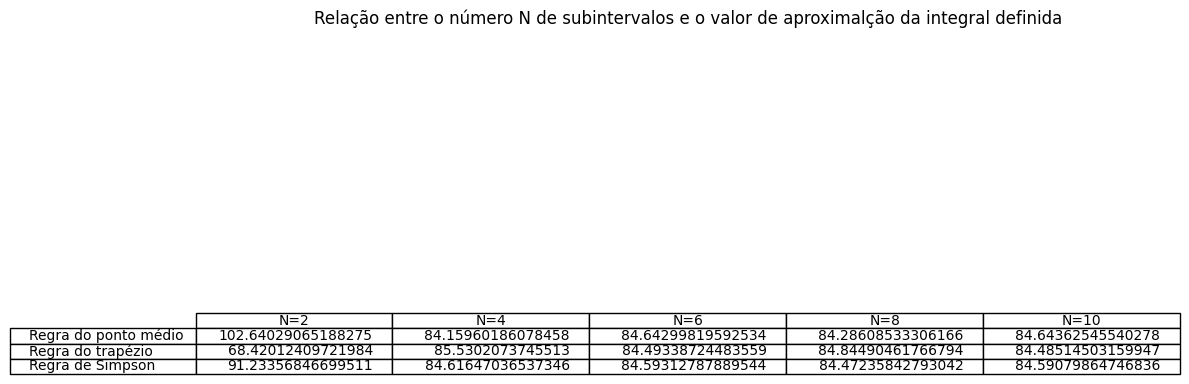

In [679]:
plot_table(relacao,colunas,linhas)